## Photometric redshift

Following the previous post about this topic I moved on with implementing the classification method of Róbert Beck, from his [article](http://adsabs.harvard.edu/abs/2016MNRAS.460.1371B). The method containg KNN finding for k >= 100 neighbors and then linear fitting as well. If there are too many outliers some values need to be dropped and the fit must be done again. Clear advantages can be seen using this approach since the fluctuation of the predicted values disappear and leaving out the outliers a much better MSE and significance can be achieved.

### 3. Local linear regression method

Reproduce the empirical photo-z method and results of Beck et al using their local linear regression method.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations as comb
from matplotlib.patches import Patch

In [4]:
file = "SDSSDR7-5-percent-err-limit-10000-line"
dataset = pd.read_csv(file+".csv")
print(dataset.columns.values)

['m_u' 'm_g' 'm_r' 'm_i' 'm_z' 'pm_u' 'pm_g' 'pm_r' 'pm_i' 'pm_z' 'ext_u'
 'ext_g' 'ext_r' 'ext_i' 'ext_z' 'ug' 'gr' 'ri' 'iz' 'p_ug' 'p_gr' 'p_ri'
 'p_iz' 'z']


In [5]:
beck_columns = ['m_r', 'ug', 'gr', 'ri', 'iz'] # 5 dimensions

In [6]:
# Creating training and test sets from data
mask = np.random.rand(len(dataset)) < 0.8 # make the test set more then 20% of the dataset
# Convert masked data to np array
train = dataset[~mask]
test = dataset[mask]

In [7]:
print(train.shape, test.shape)

(1963, 24) (8037, 24)


In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression

In [9]:
# Linear fitter for the provided training set
def linfit(x_train, y_train):
    reg = LinearRegression()
    fit = reg.fit(x_train, y_train)
    return reg

# Predict redshift based on a linear model
def predict_redshift(x_train, y_train, y_test):
    reg = linfit(x_train, y_train)
    return reg.predict(y_test.reshape(1,-1))

# Remove outliers
def calc_excluded_indices(x_reg, y_reg, k):
    deltas = []
    linreg = linfit(x_reg, y_reg)
    y_pred = linreg.predict(x_reg)
    delta_y_pred = np.sqrt(np.sum(np.square(y_reg-y_pred))/k)
    for ind in range(y_reg.size):
        err = np.linalg.norm(y_reg[ind] - y_pred[ind])
        if 3*delta_y_pred < err:
            deltas.append(ind)
    return deltas

# Subtract mean and divide by standard deviation to get 0 mean and 1 standard deviation
def normalize_dataframe(data, labels):
    df = data[labels].subtract(data[labels].mean(axis=1), axis=0)
    return df.divide(df.std(axis=1), axis=0)

def beck_method(test, train, labels, k=100):
    prediction = []
    # Normalize dataframes, test and train for appropiate labels
    df = normalize_dataframe(train, labels)
    test_df = normalize_dataframe(test, labels)
    # Fit the training data
    neigh = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
    neigh.fit(df.values)
    # Do the prediction
    for point in test_df.values:
        indices = neigh.kneighbors([point], return_distance=False)[0,:]
        redshift = predict_redshift(df.values[indices], train['z'].values[indices], point)
        # Calculate excluded indices
        deltas = calc_excluded_indices(df.values[indices], train['z'].values[indices], k)
        #Redo fit
        prev_size = indices.size
        indices = np.delete(indices, deltas)
        if indices.size < prev_size:
            redshift = predict_redshift(df.values[indices], train['z'].values[indices], point)
        prediction.append(redshift)
    return np.array(prediction)

In [10]:
# Make a prediction using k nearest neighbors
pred = beck_method(test, train, beck_columns, k=166)

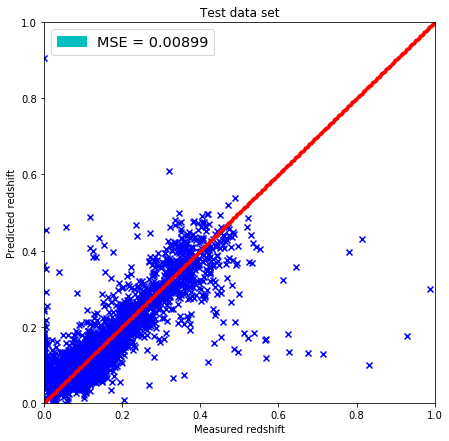

In [11]:
y_test = test['z'].values
y_test = y_test.reshape(y_test.size, 1)

# Calculating the MSE
MSE = np.sum(np.square(pred-y_test))/pred.size

# Showing the prediction accuracy
plt.figure(figsize=(7.,7.))
plt.scatter(test['z'].values, pred, marker='x', c='b')
plt.xlim(0,1)
plt.ylim(0,1)
lin = np.linspace(0,1,300)
plt.plot(lin, lin, 'r.')
plt.title('Test data set')
plt.xlabel('Measured redshift')
plt.ylabel('Predicted redshift')
legend_handle = [Patch(facecolor='c', edgecolor='c',
                         label=('MSE = %.5f' % MSE) )]
plt.legend(handles=legend_handle, loc='upper left', fontsize='x-large')
# Saving to file
plt.savefig(file+".png", dpi=166)

In [16]:
# Calculating the errors
y_train = y_test
errs = np.abs(pred-y_train.reshape(y_train.shape[0], 1))/y_train.shape[0]
sigma = np.std(errs)
y_train = y_train.reshape(y_train.shape[0], 1)

In [17]:
non_outliers = []
outliers = []
for ind in range(0, errs.size):
    if errs[ind] < 3*sigma:
        non_outliers.append(ind)
    else:
        outliers.append(ind)

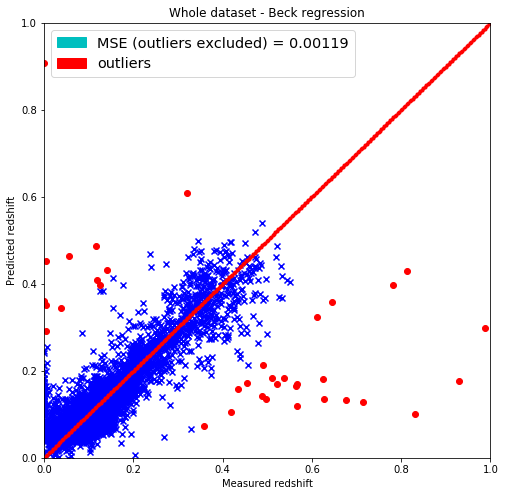

In [18]:
# Plotting the results
plt.figure(figsize=(8.,8.))

# Removing outliers from both predicted_redshift, and y_train sets
predicted_redshift_og = pred
predicted_redshift = predicted_redshift_og[non_outliers]
outlier_redshift = predicted_redshift_og[outliers]
# Same for measured redshifts
y_train_og = y_train
y_train = y_train_og[non_outliers]
outlier_y = y_train_og[outliers]

# Getting the mean squared error
MSE = np.sum(np.square(predicted_redshift-y_train))/y_train.shape[0]

plt.scatter(y_train, predicted_redshift, c='b', marker='x')
plt.scatter(outlier_y, outlier_redshift, c='r', marker='o')
plt.xlim(0,1)
plt.ylim(0,1)
lin = np.linspace(0,1,300)
plt.scatter(lin, lin, c='r', marker='.')
plt.title('Whole dataset - Beck regression')
plt.xlabel('Measured redshift')
plt.ylabel('Predicted redshift')
legend_handle = [Patch(facecolor='c', edgecolor='c',
                         label=('MSE (outliers excluded) = %.5f' % MSE)),
                Patch(facecolor='r', edgecolor='r',
                         label=('outliers'))]
plt.legend(handles=legend_handle, loc='upper left', fontsize='x-large')
plt.savefig(file+"-without-outliers.png", dpi=166)

In [30]:
import time
from sklearn.model_selection import train_test_split

def cross_validate(algo, dataset, labels, splits=5, k=10):
    MAEs = []
    MSEs = []
    start = time.time()
    for i in range(splits):
        train, test = train_test_split(dataset,
                            test_size=(1.-1./splits),
                            random_state=42*(k-i)+i*137)
        y_test = test['z'].values
        pred = algo(test, train, labels, k)
        y_test = y_test.reshape(y_test.size, 1)
        # Calculating the MAE and MSE
        MAE = np.sum(np.abs(pred-y_test))/pred.size
        MSE = np.sum(np.square(pred-y_test))/pred.size
        MAEs.append(MAE)
        MSEs.append(MSE)
    print("Mean MAE : %.5f" % np.mean(MAEs))
    print("\tStandard deviation of MAE : %.5f" % np.std(MAEs))
    print("Mean MSE : %.5f" % np.mean(MSEs))
    print("\tStandard deviation of MSE : %.5f" % np.std(MSEs))
    end = time.time()
    print("The operation took %.2f seconds.\n\n" % (end-start))

In [31]:
cross_validate(beck_method, dataset, beck_columns, splits=5, k=100)

Mean MAE : 0.02670
	Standard deviation of MAE : 0.00042
Mean MSE : 0.00690
	Standard deviation of MSE : 0.00071
The operation took 178.60 seconds.


